# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement a simple linear image models on MNIST using Estimator.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [1]:
import os
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.5'  # Tensorflow version

In [ ]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

## Exploring the data

Let's download MNIST data and examine the shape. We will need these numbers ...

In [11]:
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
print mnist.train.images.shape
print mnist.train.labels.shape

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)
(55000, 10)


In [4]:
HEIGHT=28
WIDTH=28
NCLASSES=10

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


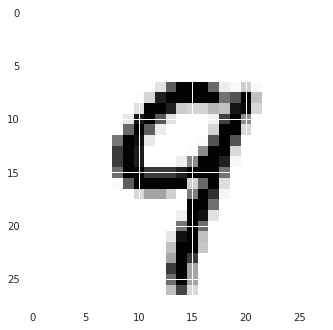

In [5]:
import matplotlib.pyplot as plt
IMGNO=12
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return logits.

In [6]:
def linear_model(img):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  W = tf.get_variable("W", [HEIGHT*WIDTH,NCLASSES], 
                      initializer = tf.truncated_normal_initializer(stddev=0.1,seed = 1))
  b = tf.get_variable("b",NCLASSES, initializer = tf.zeros_initializer)
  ylogits = tf.matmul(X,W)+b
  return ylogits, NCLASSES

## Write the harness

As usual, we need to specify input functions for training, evaluation, and predicition.

In [7]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.train.images},
    y=mnist.train.labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
  )

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.test.images},
    y=mnist.test.labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
  )

def serving_input_fn():
    inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
    features = inputs # as-is
    return tf.estimator.export.ServingInputReceiver(features, inputs)

I could have simply used a LinearClassifier, but later on, I will want to use different models, and so let's write a custom estimator

In [8]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ylogits, labels=labels))
    evalmetrics =  {'accuracy': tf.metrics.accuracy(classes, tf.argmax(labels, 1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                 learning_rate=params['learning_rate'], optimizer="Adam")
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
 
  return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"probabilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={'classes': tf.estimator.export.PredictOutput({"probabilities": probabilities, "classes": classes})}
    )

 tf.estimator.train_and_evaluate does distributed training.

In [9]:
def train_and_evaluate(output_dir, hparams):
  estimator = tf.estimator.Estimator(model_fn = image_classifier,
                                     params = hparams,
                                     model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn,
                                    max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn,
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

This is the main() function

In [ ]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {'train_steps': 1000, 'learning_rate': 0.01}
train_and_evaluate(OUTDIR, hparams)

## Run as a Python module

Let's run it as Python module

In [ ]:
%bash
rm -rf mnistmodel.tar.gz mnist_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/mnistmodel
python -m trainer.task \
   --output_dir=${PWD}/mnist_trained \
   --train_steps=10 --learning_rate=0.01 --job-dir=./tmp

Now, let's do it on ML Engine

In [ ]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC_GPU \
   --runtime-version=$TFVERSION \
   -- \
   --output_dir=$OUTDIR \
   --train_steps=1000 --learning_rate=0.01

About ten minutes later, the job finished, and I got:
<pre>
Saving dict for global step 1000: accuracy = 0.9273, global_step = 1000, loss = 0.266696
</pre>
In other words, we achieved 93% accuracy with the simple linear model.

## Deploying and predicting with model

Deploy the model:

In [ ]:
%bash
MODEL_NAME="mnist"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained/export/Servo | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

To predict with the model, let's take one of the example images.

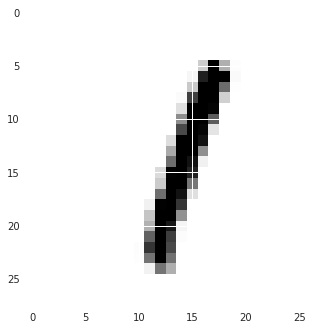

In [16]:
import json, codecs
import matplotlib.pyplot as plt
IMGNO=5
jsondata = {'image': [mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()]}
json.dump(jsondata, codecs.open('test.json', 'w', encoding='utf-8'))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [17]:
%bash
gcloud ml-engine predict --model=mnist --version=v1 --json-instances=./test.json

CLASSES  PROBABILITIES
1        [2.4010306631794265e-08, 0.9978127479553223, 0.00029019746580161154, 0.0009130405960604548, 1.8982924530064338e-06, 7.585201274196152e-06, 3.50063118048638e-07, 0.0006381778512150049, 0.0002849253360182047, 5.102611248730682e-05]


Here is another way to invoke the prediction service, this time from Python:

In [18]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json, codecs

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

request_data = {'instances':
  [
      {
        'image': [mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()]
      }
     for IMGNO in [12, 5]
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'mnist', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print "response={0}".format(response)

response={u'predictions': [{u'probabilities': [2.939294063253328e-06, 1.449641739981189e-08, 3.092995393672027e-05, 0.00013781529560219496, 0.0034942335914820433, 0.0002616374986246228, 2.826582203852013e-07, 0.00635492755100131, 0.0010547968558967113, 0.9886624217033386], u'classes': 9}, {u'probabilities': [2.4010306631794265e-08, 0.9978127479553223, 0.00029019746580161154, 0.0009130397811532021, 1.8982906340170302e-06, 7.5851939982385375e-06, 3.5006243592761166e-07, 0.0006381775601767004, 0.00028492481214925647, 5.102611248730682e-05], u'classes': 1}]}


In [19]:
print [(pred['classes'], pred['probabilities'][pred['classes']]) for pred in response['predictions']]

[(9, 0.9886624217033386), (1, 0.9978127479553223)]


<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>